In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from PIL import Image, ImageFilter
from datasets import load_dataset
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import random_split 
from sklearn.model_selection import train_test_split

#This file trains resnet50 as an end-to-end classifier and saves the weights so that they can be frozen and used in NTS architecture



In [9]:
#------------------------------------data--------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dataset = load_dataset("tanganke/stanford_cars")



base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # required for resnet mean
        std=[0.229, 0.224, 0.225]    # required for resnet standard dev
    )
])




augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1))),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x)),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # required for resnet mean
        std=[0.229, 0.224, 0.225]    # required for resnet standard dev
    )
])

class StanfordCarsDataset(Dataset):
    def __init__(self, hf_dataset, transform):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        example = self.hf_dataset[idx]
        img = example['image'].convert('RGB')
        label = example['label']
        img = self.transform(img)
        return img, torch.tensor(label)


# --- create an 80 / 10 / 10 split (train / val / test) ---
train_len   = int(0.8 * len(dataset["train"]))
val_len     = len(dataset["train"]) - train_len
train_idx, val_idx = train_test_split(
    np.arange(len(dataset['train'])),
    test_size=0.2,
    stratify=dataset['train']['label'],
    random_state=42,
)
hf_train = dataset['train'].select(train_idx)
hf_val   = dataset['train'].select(val_idx)

train_base = StanfordCarsDataset(hf_train, base_transform)
train_aug  = StanfordCarsDataset(hf_train, augment_transform)
train_combined = ConcatDataset([train_base, train_aug])

val_set  = StanfordCarsDataset(hf_val,  base_transform)
test_set = StanfordCarsDataset(dataset["test"], base_transform)




In [10]:
torch.cuda.empty_cache()

In [11]:

# Hyperparameters:

batch_size = 64
learning_rate = 1e-4
epochs = 10

train_loader = DataLoader(train_combined, batch_size, shuffle=True)
val_loader   = DataLoader(val_set,       batch_size, shuffle=False)
test_loader  = DataLoader(test_set,      batch_size, shuffle=False)

#-----------------------define and train model------------------------------


# Define model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# model = resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, 196)  # 196 classes in Stanford Cars
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

# Training loop
save_path = "resnet50_stanfordcars.pth"

train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

for epoch in range(epochs):
    # ---------- training ----------
    model.train()
    running_loss = correct = total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = outputs.max(1)
        total   += labels.size(0)
        correct += pred.eq(labels).sum().item()

    tr_loss = running_loss / len(train_loader)
    tr_acc  = 100 * correct / total
    train_loss_hist.append(tr_loss)
    train_acc_hist.append(tr_acc)

    # ---------- validation ----------
    model.eval()
    running_loss = correct = total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, pred = outputs.max(1)
            total   += labels.size(0)
            correct += pred.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc  = 100 * correct / total
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.2f}%   "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")




Epoch [1/10] Train Loss: 3.9688 | Train Acc: 21.00%   Val Loss: 2.6396 | Val Acc: 41.44%
Epoch [2/10] Train Loss: 1.5331 | Train Acc: 70.34%   Val Loss: 1.2875 | Val Acc: 70.35%
Epoch [3/10] Train Loss: 0.4899 | Train Acc: 91.83%   Val Loss: 0.8998 | Val Acc: 77.35%
Epoch [4/10] Train Loss: 0.1535 | Train Acc: 98.27%   Val Loss: 0.7777 | Val Acc: 80.91%
Epoch [5/10] Train Loss: 0.0607 | Train Acc: 99.49%   Val Loss: 0.7093 | Val Acc: 82.75%
Epoch [6/10] Train Loss: 0.0318 | Train Acc: 99.71%   Val Loss: 0.7201 | Val Acc: 81.40%
Epoch [7/10] Train Loss: 0.0262 | Train Acc: 99.69%   Val Loss: 0.6660 | Val Acc: 82.07%
Epoch [8/10] Train Loss: 0.0219 | Train Acc: 99.74%   Val Loss: 0.6992 | Val Acc: 82.07%
Epoch [9/10] Train Loss: 0.0137 | Train Acc: 99.82%   Val Loss: 0.6546 | Val Acc: 83.61%
Epoch [10/10] Train Loss: 0.0090 | Train Acc: 99.85%   Val Loss: 0.6567 | Val Acc: 83.36%


In [12]:
# Save the model
torch.save(model.state_dict(), save_path)
print(f"Saved trained ResNet-50 weights to '{save_path}'")


Saved trained ResNet-50 weights to 'resnet50_stanfordcars.pth'


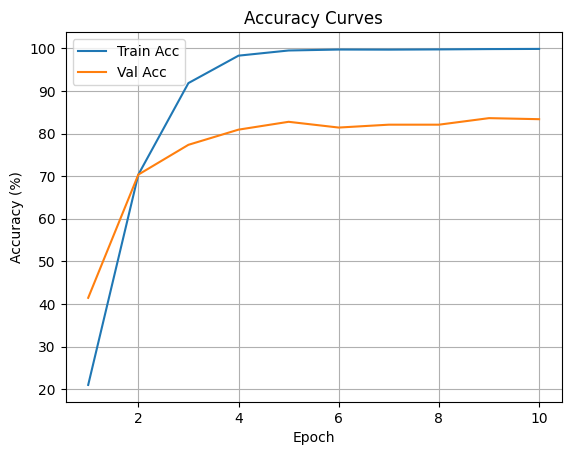

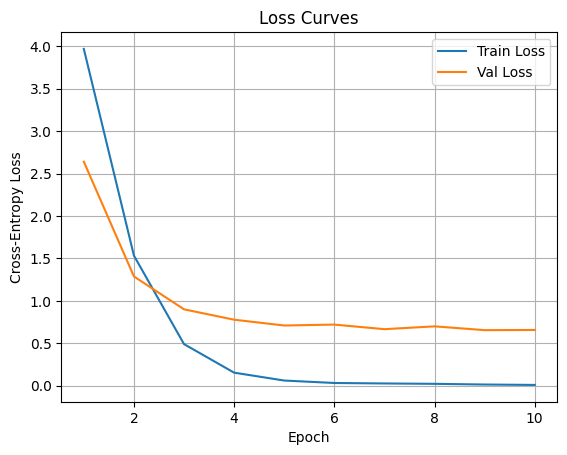

In [13]:
# Accuracy curve
plt.figure()
plt.plot(range(1, epochs+1), train_acc_hist, label="Train Acc")
plt.plot(range(1, epochs+1), val_acc_hist,   label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curves")
plt.legend(); plt.grid(True)
plt.show()

# Loss curve (optional)
plt.figure()
plt.plot(range(1, epochs+1), train_loss_hist, label="Train Loss")
plt.plot(range(1, epochs+1), val_loss_hist,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Cross‑Entropy Loss")
plt.title("Loss Curves")
plt.legend(); plt.grid(True)
plt.show()


In [ ]:
#----------------Testing---------------------
# Step 1: Rebuild the same model architecture
model = resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, 196)
model.load_state_dict(torch.load("resnet50_stanfordcars.pth"))
model = model.to(device)
model.eval()

# Step 2: Evaluate on the test set
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

C:\Users\yangh\AppData\Local\Temp\ipykernel_16464\3525452944.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet50_stanfordcars.pth"

Test Accuracy: 83.63%
